# Plot the very long term trajectories of stars on the sky

Calculate the celestial positions for sources for future epochs and plot the resulting trajectory of the stars on the sky. The aim is to reproduce the GaiaSky produced version that Stefan Jordan proposed as Gaia EDR3 release image.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, rc
from matplotlib.colors import LogNorm

from astropy.table import Table
import astropy.units as u

import cartopy.crs as ccrs
import healpy as hp

from astroquery.simbad import Simbad
from pygaia.astrometry.coordinates import EpochPropagation, CoordinateTransformation, Transformations

## Barnard's star as test case

In [8]:
barnard_edr3 = Table.read('BarnardsStar.vot', format='votable')

customSimbad = Simbad()
customSimbad.add_votable_fields('rv_value', 'rvz_error')
barnard_simbad = customSimbad.query_object("Barnard's star")

In [9]:
n_epochs = 1000
delta_epoch = 8.0e+5
t0=2016.0
epp = EpochPropagation()
epochs = np.linspace(t0, t0+delta_epoch, n_epochs)

ra = np.zeros_like(epochs)
dec = np.zeros_like(epochs)

for i, t1 in zip(range(n_epochs), epochs):
    ra[i], dec[i] = epp.propagate_pos(np.deg2rad(barnard_edr3['ra'][0]), np.deg2rad(barnard_edr3['dec'][0]), 
                                      barnard_edr3['parallax'][0], barnard_edr3['pmra'][0], 
                                      barnard_edr3['pmdec'][0], barnard_simbad['RV_VALUE'][0], t0, t1)
        
ra = np.rad2deg(ra)
dec = np.rad2deg(dec)

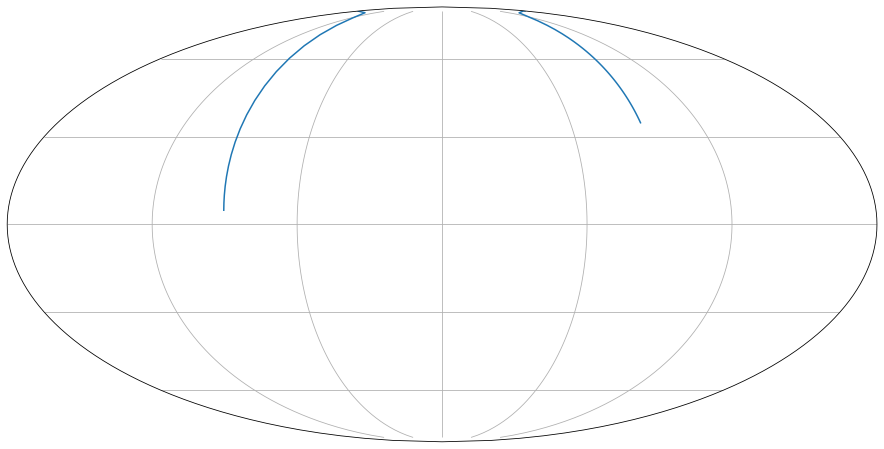

In [11]:
defaultProj = ccrs.PlateCarree()
skyProj = ccrs.Mollweide()

rc('font', family='sans-serif', size=18)

fig=plt.figure(figsize=(16,8))

ax = fig.add_subplot(projection=skyProj)
ax.plot(ra, dec, transform=defaultProj)
ax.invert_xaxis()
ax.gridlines()
ax.set_global()

plt.show()

## Background image options

In [4]:
hplevel=9
nside = hp.order2nside(hplevel)
npix = hp.nside2npix(nside)
hpcol = 'healpix_{0}'.format(hplevel)
fileName = "SourceCountsHp9.fits"
edr3data = Table.read(fileName, format='fits')

hpmap = np.zeros(npix)
hpmap[:] = hp.pixelfunc.UNSEEN
hpmap[edr3data[hpcol]] = edr3data['num_sources']
hpsourcemap = hp.visufunc.cartview(hpmap, coord=['C','G'], nest=True, title='', 
                             unit='', cbar=False, notext=True,
                             return_projected_map=True, flip='geo')
plt.close()

dr2sky = plt.imread('/home/brown/Gaia/Presentation/Images/GaiaSky/GaiaDR2/ESA-PR/' + 
                    'ESA_Gaia_DR2_AllSky_Brightness_Colour_Cartesian_2000x1000.png')

/home/brown/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:907: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/brown/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:908: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/brown/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:909: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a 

## Sample of stars

In [5]:
data = Table.read('/home/brown/Gaia/EDR3-exploration/6DGold/GaiaEDR3-6DGold.fits', format='fits')

#slice_dist = (data['parallax']**2 - 2*data['parallax'] - data['parallax_error']**2 < -1) & \
#               (data['parallax_over_error']>=10)
slice_dist = (data['parallax']>10) & (data['parallax_over_error']>=10)
print(data['ra'][slice_dist].size)
nsample = 2000
raninds = np.random.choice(np.arange(data['ra'][slice_dist].size), nsample)

ra0 = np.deg2rad(data['ra'][slice_dist][raninds])
dec0 = np.deg2rad(data['dec'][slice_dist][raninds])
plx0 = data['parallax'][slice_dist][raninds]
pmra0 = data['pmra'][slice_dist][raninds]
pmdec0 = data['pmdec'][slice_dist][raninds]
vrad0 = data['dr2_radial_velocity'][slice_dist][raninds]
mag = data['phot_g_mean_mag'][slice_dist][raninds]

48961


In [12]:
ct = CoordinateTransformation(Transformations.ICRS2GAL)

delta_epoch = 8.0e+5
epochs = np.linspace(t0, t0+delta_epoch, n_epochs)

l1 = np.zeros((nsample, n_epochs))
b1 = np.zeros((nsample, n_epochs))

for i, t1 in zip(range(n_epochs), epochs):
    ra1, dec1 = epp.propagate_pos(ra0, dec0, plx0, pmra0, pmdec0, vrad0, t0, t1)
    l1[:,i], b1[:,i] = ct.transformSkyCoordinates(ra1, dec1)

l1 = np.rad2deg(l1)
b1 = np.rad2deg(b1)
print(l1.shape)

(2000, 1000)


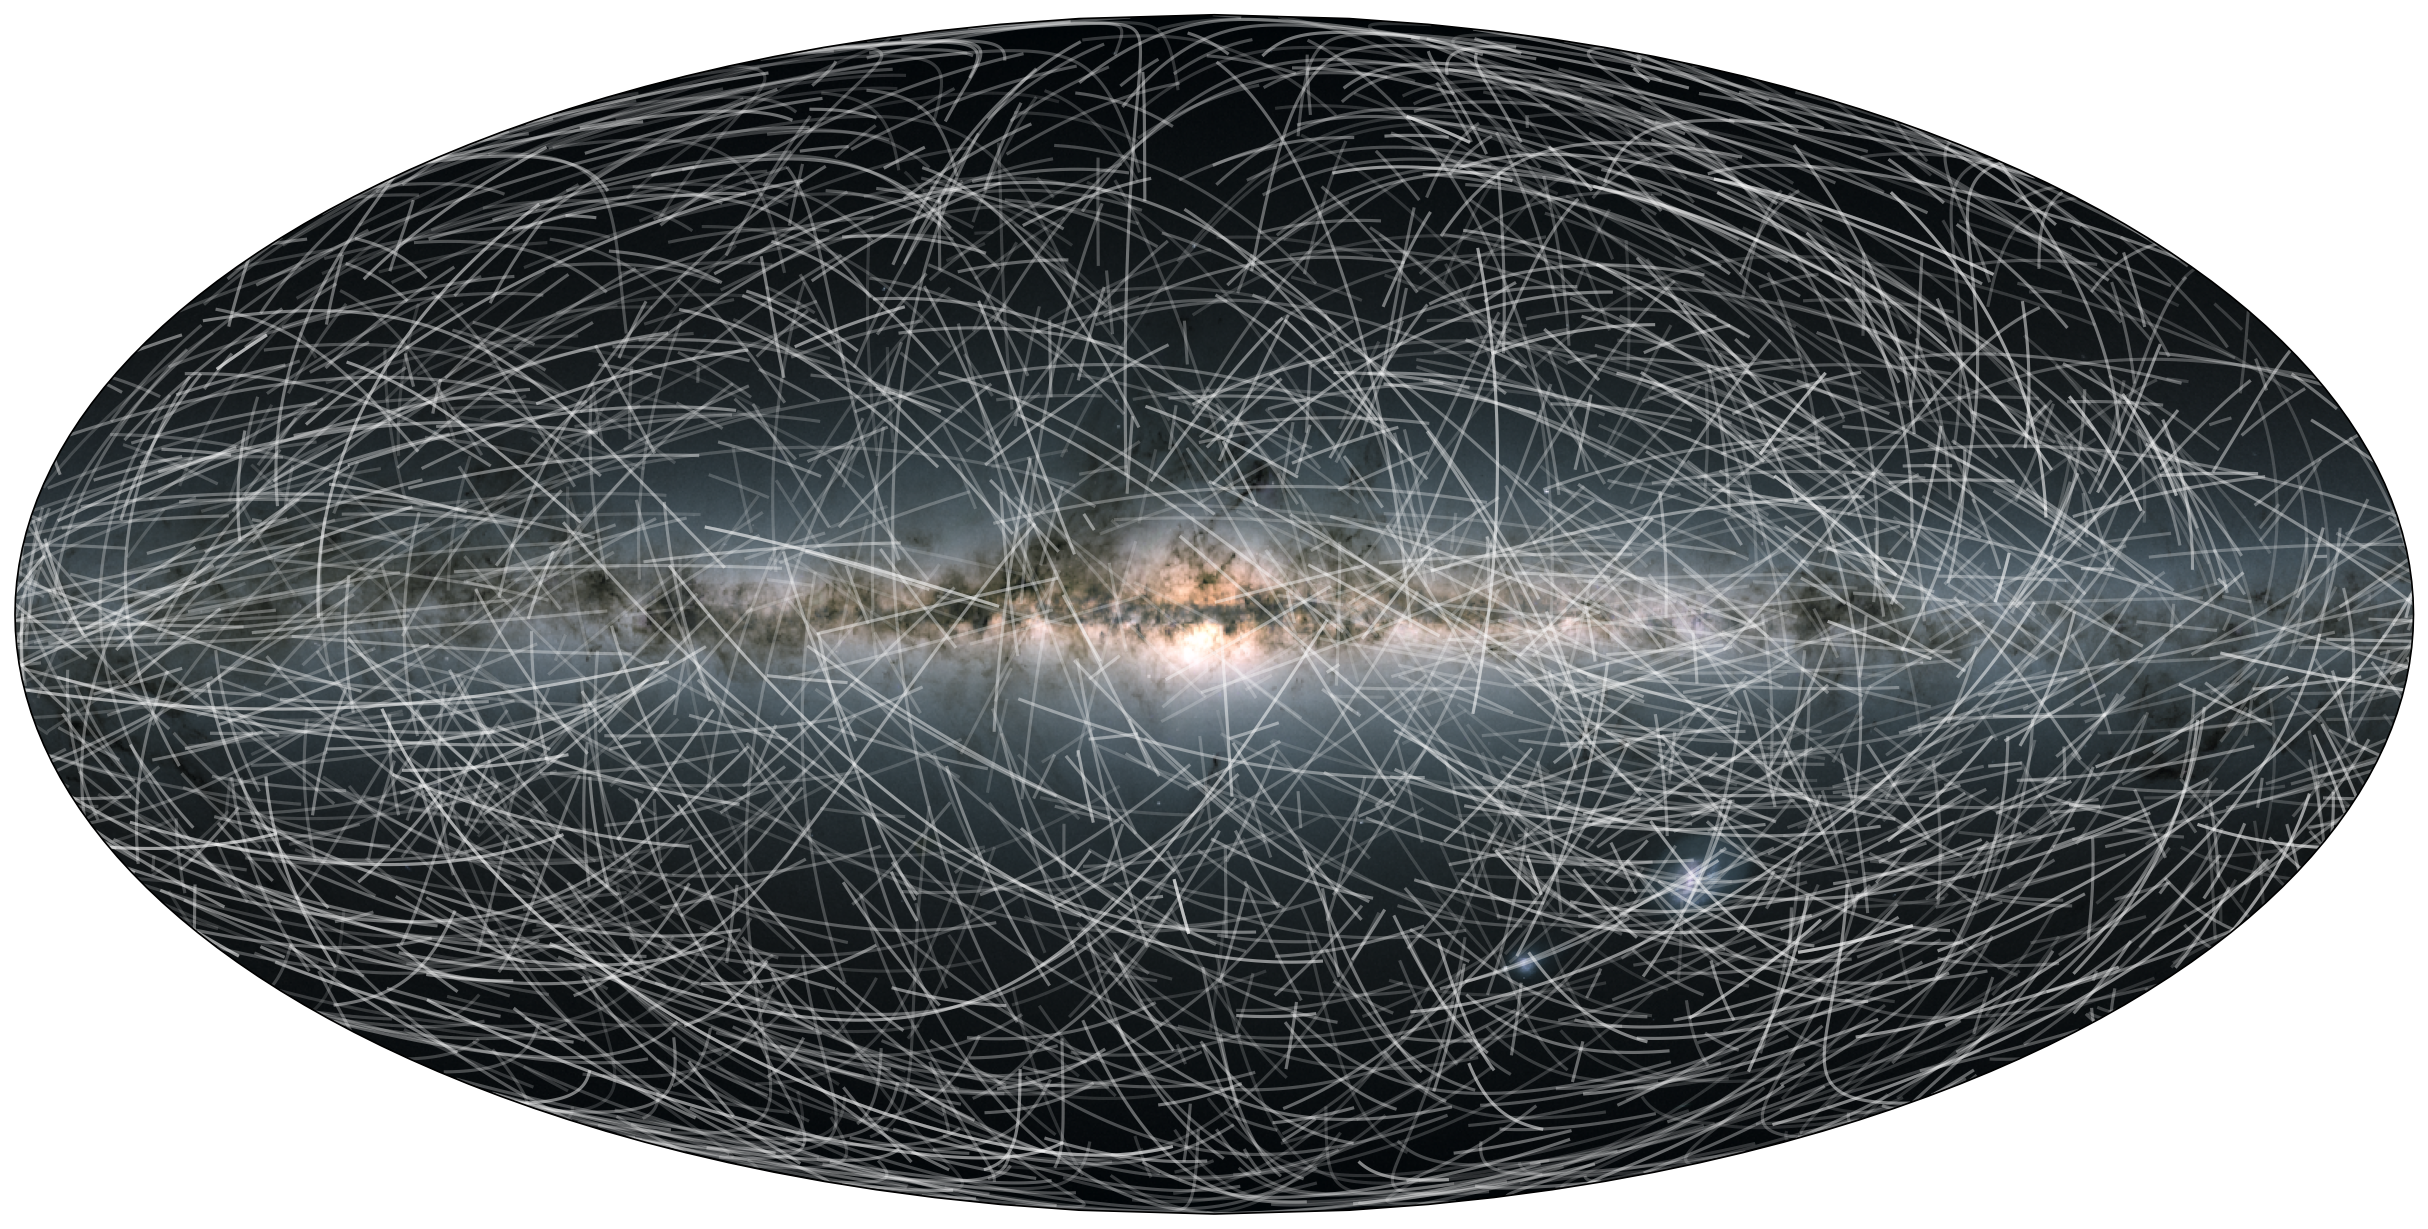

In [13]:
magrange = mag.max()-mag.min()
magscaled_trails = 0.1+0.5*(mag.max()-mag)/magrange

fig=plt.figure(figsize=(16,8), dpi=150, frameon=False, tight_layout={'pad':0.01})

ax1 = fig.add_subplot(projection=skyProj)
#ax1.imshow(hpsourcemap, transform=defaultProj, cmap=cm.Greys_r, norm=LogNorm(), zorder=-1, origin='lower')
ax1.imshow(np.fliplr(dr2sky), transform=defaultProj, zorder=-1, origin='upper')
for i in range(nsample):
    l = l1[i,:]
    b = b1[i,:]
    l[l>180] = l[l>180]-360.0
    diffs = l[1:]-l[0:-1]
    if np.all(diffs>0) or np.all(diffs<0):
        ax1.plot(l, b, c='w', alpha=magscaled_trails[i], transform=defaultProj)
    else:
        indices=(l>=0.0)
        if np.any(indices):
            xplot=l[indices]
            yplot=b[indices]
            ax1.plot(xplot, yplot, c='w', alpha=magscaled_trails[i], transform=defaultProj)
        indices=(l<0.0)
        if np.any(indices):
            xplot=l[indices]
            yplot=b[indices]
            ax1.plot(xplot, yplot, c='w', alpha=magscaled_trails[i], transform=defaultProj)

ax1.set_global()
ax1.invert_xaxis()

plt.show()